<a href="https://colab.research.google.com/github/AnmolKumar8826/Stock-Market-AI/blob/main/stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install pandas_profiling
# !pip install --upgrade pandas-profiling


In [2]:
df = pd.read_csv("/content/drive/MyDrive/nifty_10yrs.csv")

In [3]:
# Top 5 rows of raw dataset
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2013-12-30 00:00:00+05:30,38.666786,38.695041,37.331744,37.614292,5612941,0.0,0.0,ADANIENT
1,2013-12-30 00:00:00+05:30,1593.923342,1593.923342,1553.678139,1564.609375,168075,0.0,0.0,HEROMOTOCO
2,2013-12-30 00:00:00+05:30,314.647645,314.740632,309.231520,311.253845,2113802,0.0,0.0,HDFCBANK
3,2013-12-30 00:00:00+05:30,248.808099,250.981959,243.887267,246.377319,1578700,0.0,0.0,HCLTECH
4,2013-12-30 00:00:00+05:30,397.459083,399.023178,392.174721,394.696289,241807,0.0,0.0,GRASIM


Null values in Volume --> 146 (dropped all)

issues -
1.  ***Changing datatypes***
2.  ***Dropping duplicates***
3.  ***Dropping redundant columns***
4.  ***Sorting data by company and year wise***
5.  ***Adding pct_change for Close***
6.  ***Normalizing volume***
7.  ***Reseting index***
8.  ***Adding Moving Avgs***
9.  ***Feature Engineering***
******
*resolved all*: ✅

--> ****MADE A CONSISER CODE FOR CLEANING STEP,****

--> ****RUN THIS TAB TO APPLY ALL MODIFICATIONS TO DATASET IN A SINGLE GO****

In [4]:
# 1 Dropping Duplicates
df[df[['Company','Low','High','Close','Volume']].duplicated()].sort_values(by=['Company']).head(50)

# Number of unique companies in dataset
print("Total number of Unique Companies in our dataset :",df['Company'].value_counts().shape[0])
# Number of rows in data
print("Total number of rows we have :",df.shape[0])

# 2 Changing datatypes :
df.drop(107568,inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = pd.to_datetime(df['Date'])
df['Company'] = df['Company'].astype('category')
df.reset_index()

# 3 Dropping redundant columns:
print(df[df["Dividends"] != 0].shape[0],'There were only this much values in "Divident" column out of 120842, so we dropped that') # 709 values only out of 120842
print(df[df["Stock Splits"] != 0].shape[0],'There were only this much values in "Stock_Splits" column out of 120842, so we dropped that') # 34 values only out of 120842
df.drop(["Dividends","Stock Splits"],axis=1,inplace=True)
# Dropping 0 values from VOLUME column
df['Volume'] = df['Volume'].replace(0, np.nan)
df.dropna(subset=['Volume'],inplace=True)



# Moving Company column to the 1st place in data:
df.insert(0, "Company", df.pop("Company"))


# 5 Sorting data company and date wise
df.sort_values(by=['Company','Date'],inplace=True)


# 6 Daily pct change when a stock closes
df['Daily_pct_change'] = df.groupby('Company')['Close'].pct_change()*100
df.fillna(method='bfill',inplace=True)


# Normalizing the value for Volume column
df['Logged_vol'] = df['Volume'].apply(lambda x: np.log(x))


# Reseting index in order from 1 to nth row
df.reset_index(drop=True,inplace=True)
df.index +=1


# check feature engineering cells

Total number of Unique Companies in our dataset : 50
Total number of rows we have : 120842
709 There were only this much values in "Divident" column out of 120842, so we dropped that
34 There were only this much values in "Stock_Splits" column out of 120842, so we dropped that


In [5]:
df.head()

,Company,Date,Open,High,Low,Close,Volume,Daily_pct_change,Logged_vol
1,ADANIENT,2013-12-30,38.666786,38.695041,37.331744,37.614292,5612941.0,-1.408458,15.540585
2,ADANIENT,2013-12-31,37.734374,37.833262,36.787836,37.084511,6290260.0,-1.408458,15.654513
3,ADANIENT,2014-01-01,37.268167,38.129941,37.056256,37.967476,7564701.0,2.380954,15.839003
4,ADANIENT,2014-01-02,37.296432,37.967487,35.784798,36.074409,17188171.0,-4.986021,16.659732
5,ADANIENT,2014-01-03,35.742403,36.173292,34.541572,35.085480,11525782.0,-2.741361,16.260097


In [ ]:
ma50= df.groupby('Company').Close.rolling(50).mean().reset_index()
ma50.drop('level_1',axis=1,inplace=True)
ma50.rename(columns={'Close':'MA50'},inplace=True)
new_dt = []



from joblib import Parallel, delayed

# Define the chunk size
chunk_size = 5000  # Number of rows to process at a time

total_chunks = len(df) // chunk_size + 1
for i in range(total_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(df))

# Define a function to merge chunks
def merge_chunks(start_idx, end_idx):
    chunk1 = df.iloc[start_idx:end_idx]
    chunk2 = ma50.iloc[start_idx:end_idx]
    return pd.merge(chunk1, chunk2, on='Company', how='inner')

# Calculate the total number of chunks based on the dataframe size and chunk size


# Create a list of chunk indices
chunk_indices = [(i * chunk_size, min((i + 1) * chunk_size, len(df))) for i in range(total_chunks)]

# Use parallel processing to merge chunks
merged_chunks = Parallel(n_jobs=-1)(delayed(merge_chunks)(*idx) for idx in chunk_indices)

# Concatenate all merged chunks into a single dataframe
merged_df = pd.concat(merged_chunks)

# Process the merged dataframe as needed


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120695 entries, 1 to 120695
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Company           120695 non-null  category      
 1   Date              120695 non-null  datetime64[ns]
 2   Open              120695 non-null  float64       
 3   High              120695 non-null  float64       
 4   Low               120695 non-null  float64       
 5   Close             120695 non-null  float64       
 6   Volume            120695 non-null  float64       
 7   Daily_pct_change  120695 non-null  float64       
 8   Logged_vol        120695 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(7)
memory usage: 7.5 MB


In [7]:
df.describe()

,Open,High,Low,Close,Volume,Daily_pct_change,Logged_vol
count,120695.000000,120695.000000,120695.000000,120695.000000,1.206950e+05,120695.000000,120695.000000
mean,1437.717450,1454.213562,1419.729204,1436.606036,7.288618e+06,0.089990,14.691009
std,2253.596364,2275.878829,2228.846742,2252.087991,1.789979e+07,1.967775,1.552803
min,15.739931,15.870457,15.332995,15.463521,3.025000e+03,-38.749258,8.014666
25%,301.696542,305.734754,296.775461,301.232178,8.749565e+05,-0.897855,13.681929
50%,679.221960,688.144168,670.700012,679.147827,2.644152e+06,0.044408,14.787861
75%,1653.916604,1674.759100,1632.199892,1652.892151,6.942764e+06,1.028359,15.753211
max,26250.000000,26650.000000,26145.650391,26580.300781,6.428460e+08,44.673086,20.281416


In [20]:
# JUSTIFICATION WHY THEIR IS A DRASTIC CHANGE IN DAILY_PCT_COLUMN (for minimum pct_change)
df.iloc[59712:59715]

,Company,Date,Open,High,Low,Close,Volume,Daily_pct_change,Logged_vol
346,ADANIENT,2015-06-02,92.044202,94.273168,89.663750,91.899933,112566102.0,0.623959,18.539051
347,ADANIENT,2015-06-03,294.038340,294.038340,54.545573,56.289391,89673759.0,-38.749258,18.311689
348,ADANIENT,2015-06-04,57.443389,61.213107,56.058593,59.777027,27138057.0,6.195904,17.116448


In [21]:
# JUSTIFICATION WHY THEIR IS A DRASTIC CHANGE IN DAILY_PCT_COLUMN (for minimum pct_change)
df.iloc[345:348]

,Company,Date,Open,High,Low,Close,Volume,Daily_pct_change,Logged_vol
346,ADANIENT,2015-06-02,92.044202,94.273168,89.663750,91.899933,112566102.0,0.623959,18.539051
347,ADANIENT,2015-06-03,294.038340,294.038340,54.545573,56.289391,89673759.0,-38.749258,18.311689
348,ADANIENT,2015-06-04,57.443389,61.213107,56.058593,59.777027,27138057.0,6.195904,17.116448


## Ploting some graphs to visualize the behaviour of **data**


# ***TOP 5 COMPANIES BY VOLUME***

      Company        Volume
0   TATASTEEL  2.131810e+11
1        SBIN  6.177107e+10
2  TATAMOTORS  5.581533e+10
3   ICICIBANK  4.687470e+10
4         ITC  3.776769e+10


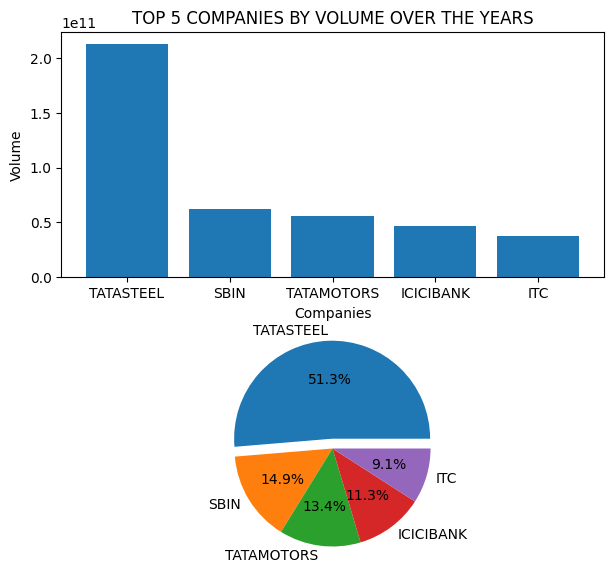

In [22]:
top_5cmpny = df.groupby("Company")["Volume"].sum()
top_5cmpny = top_5cmpny.sort_values(ascending=False).head().reset_index()

print(top_5cmpny)
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(7,7))

ax[1].pie(top_5cmpny["Volume"],autopct="%0.1f%%",labels=top_5cmpny["Company"],explode=[0.1,0,0,0,0])
ax[0].bar(top_5cmpny["Company"],top_5cmpny["Volume"])

ax[0].set_title("TOP 5 COMPANIES BY VOLUME OVER THE YEARS")
ax[0].set_xlabel("Companies")
ax[0].set_ylabel("Volume")


fig.show()

***Plotting HIGH vs LOW to ensure data Integrity***

* NOTE -->>

****YOU CAN GIVE A COMPANY'S NAME AS INPUT,AND FURTHER GRAPHS WILL BE PLOTED ON TOP OF THAT PARTICULAR COMPANY'S DATA ****

Company name : tatasteel


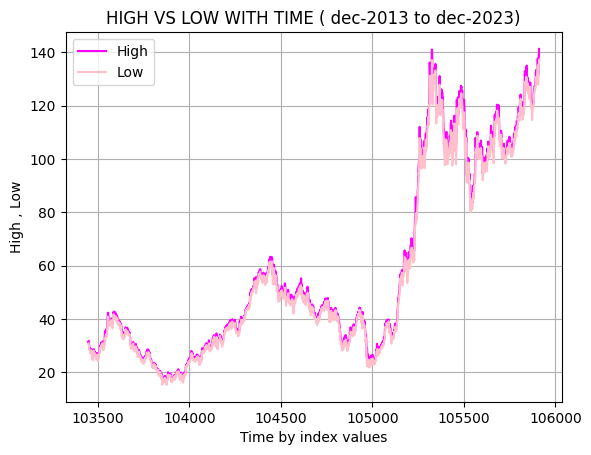

In [25]:
x = input("Company name : ").upper()            # Execute these 2 lines for selecting the company !! <-- Line 1
Company_df = df[df["Company"]==x]       #                                                    <-- Line 2

plt.plot(Company_df["High"],label="High",color="magenta")
plt.title("HIGH VS TIME ( dec-2013 to dec-2023) in days")
plt.xlabel("Time by index values")
plt.ylabel("HIGH")

# For low column graph
plt.plot(Company_df["Low"],color='pink',label="Low")
plt.title("HIGH VS LOW WITH TIME ( dec-2013 to dec-2023)")
plt.xlabel("Time by index values")
plt.ylabel("High , Low")

plt.legend()
plt.grid()
plt.show()

In [28]:
# To cross-check that really a stock got a hike ??
# USE = enter a value from the x axis (Time by index values) to cross-check real data (will show real data upto 50 rows to match trends)
ind = int(input("Enter index value : "))
c = Company_df.reset_index()
c[c['index']>ind].head(50)

Enter index value : 105200


,index,Company,Date,Open,High,Low,Close,Volume,Daily_pct_change,Logged_vol
1753,105201,TATASTEEL,2021-02-12,62.459851,62.720476,60.976990,61.156734,147054790.0,-2.044041,18.806316
1754,105202,TATASTEEL,2021-02-15,61.749870,61.830757,60.213089,60.406307,131716720.0,-1.227056,18.696164
1755,105203,TATASTEEL,2021-02-16,60.406310,63.682086,60.060315,62.837303,336618380.0,4.024407,19.634460
1756,105204,TATASTEEL,2021-02-17,62.698005,63.223746,61.785822,62.621616,159574830.0,-0.343246,18.888024
1757,105205,TATASTEEL,2021-02-18,62.909200,63.897772,62.369980,62.706993,148561470.0,0.136337,18.816509
1758,105206,TATASTEEL,2021-02-19,62.549714,62.549714,58.950412,60.275997,223923860.0,-3.876754,19.226817
1759,105207,TATASTEEL,2021-02-22,60.473713,62.720470,60.289477,61.520702,281491090.0,2.065010,19.455611
1760,105208,TATASTEEL,2021-02-23,61.974545,66.144526,61.309507,65.542397,389070710.0,6.537140,19.779272
1761,105209,TATASTEEL,2021-02-24,66.054654,66.953357,64.706600,65.398598,216767890.0,-0.219398,19.194338
1762,105210,TATASTEEL,2021-02-25,66.072628,67.672325,65.780552,66.764633,219015960.0,2.088784,19.204655


***Plotting Boxplots to detect outliers***

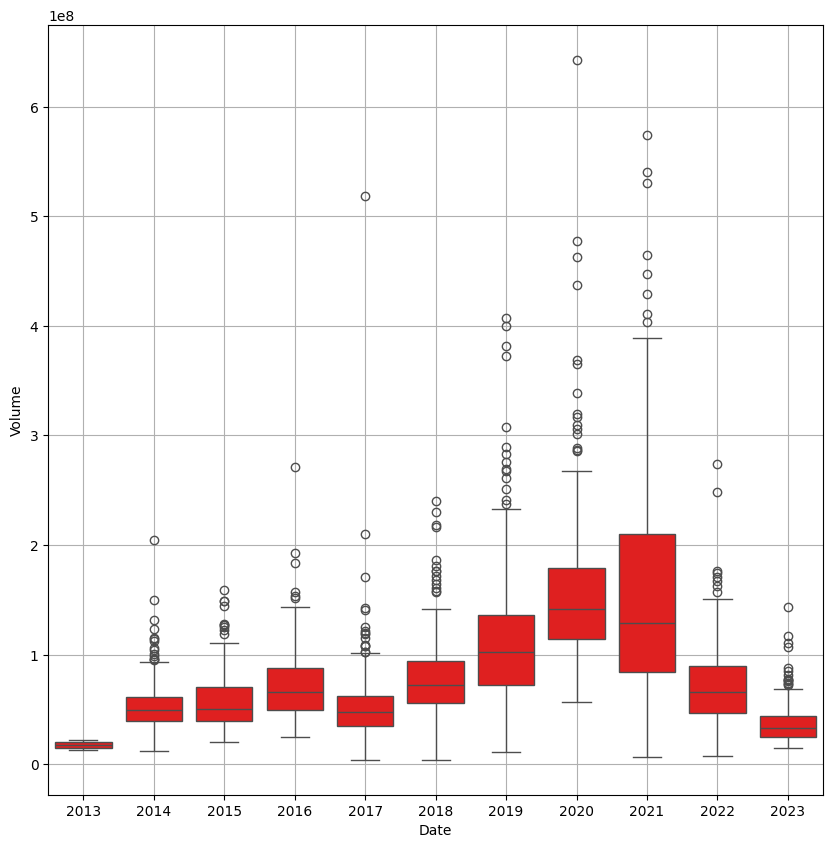

In [29]:
# BOX_PLOTS for detecting outliers
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x=Company_df["Date"].dt.year ,y=Company_df["Volume"],color='r')
fig.show()
plt.grid()

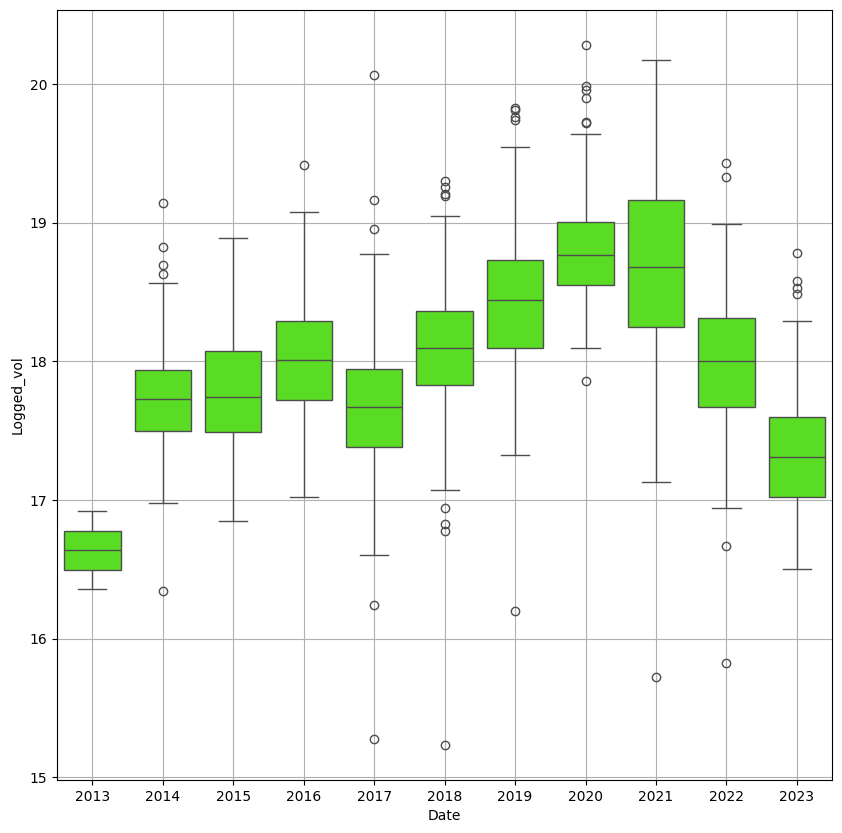

In [30]:
# Applied LOG transformation on top of Volume Column

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x=Company_df["Date"].dt.year ,y=Company_df["Logged_vol"],color='#4efa05')
fig.show()
plt.grid()

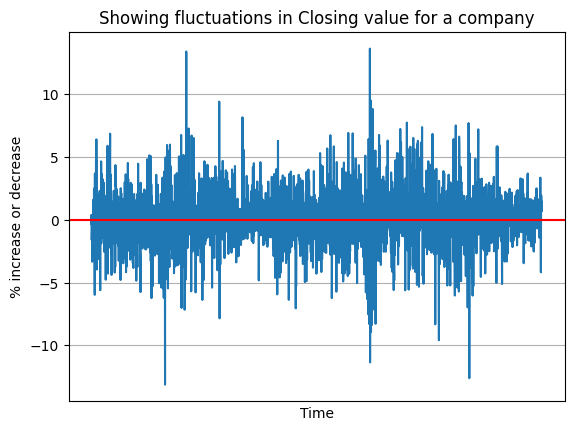

In [31]:
# Daily Pct_Change with respect to close column for every Company

plt.plot(Company_df['Daily_pct_change'])
plt.title('Showing fluctuations in Closing value for a company')
plt.xlabel('Time')
plt.ylabel('% increase or decrease')
plt.axhline(y=0,color='r')
plt.xticks([])
plt.grid(True)

## ***FEATURE*** ***ENGINEERING***

adding new attributes

2.   Moving_avg_50
3.   Moving_avg_200





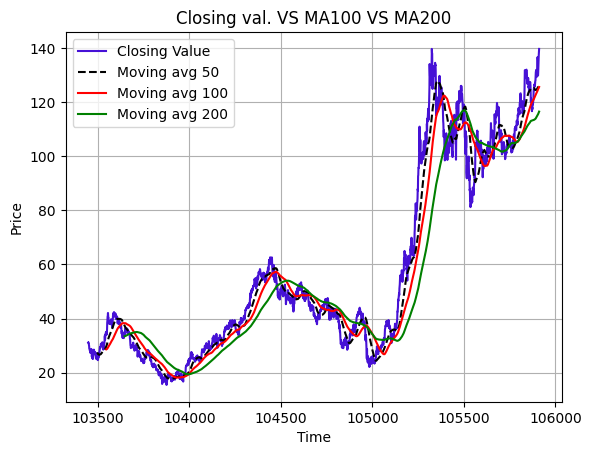

In [32]:
# Moving avg (MAn) : will take the previous n values and gonna predict a graph. This will help to analyze the trend of a particular stock


MA100 = Company_df["Close"].rolling(100).mean()
MA200 = Company_df["Close"].rolling(200).mean()
MA50 = Company_df["Close"].rolling(50).mean()


plt.plot(Company_df['Close'],color='#4611d6',label='Closing Value')
plt.plot(MA50,color='black',label='Moving avg 50',linestyle='dashed')
plt.plot(MA100,color='red',label='Moving avg 100')
plt.plot(MA200,color='green',label='Moving avg 200')

plt.title('Closing val. VS MA100 VS MA200')
plt.ylabel('Price')
plt.xlabel('Time')

plt.legend()
plt.grid()
plt.show()

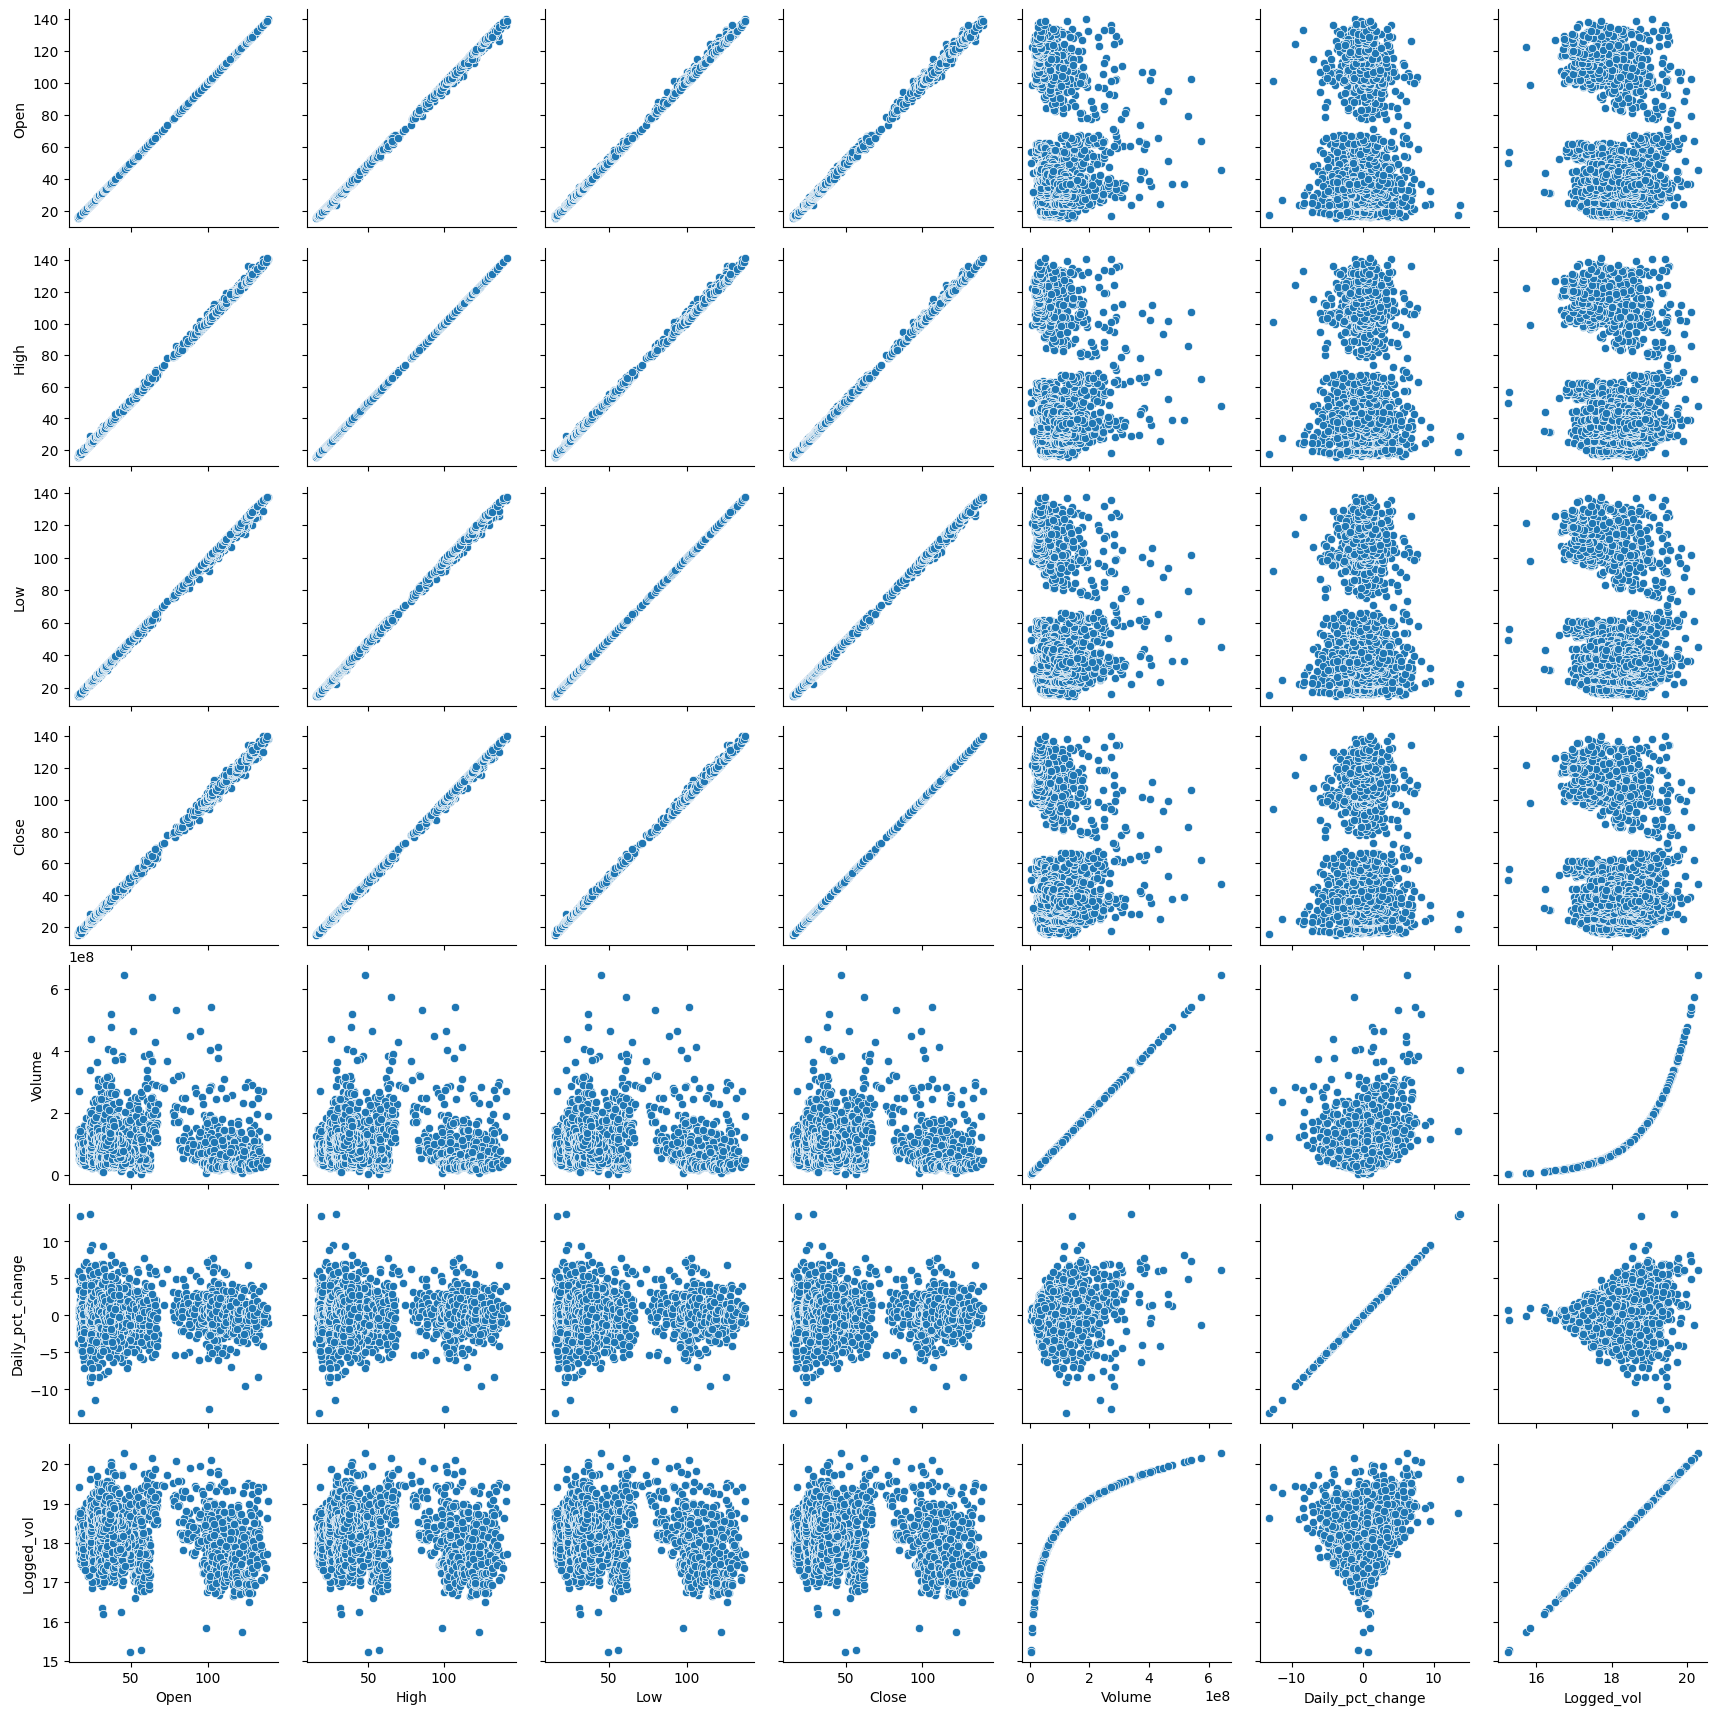

In [33]:

# HELPS THAKING A ROUGH IDEA THAT HOW DIFFRENT COLUMNS ARE BEHAVING WITH EACH OTHER

g = sns.PairGrid(data=Company_df)
g.map(sns.scatterplot)

***Taking out few columns for MACHINE LEARNING and applying ONE_HOT ENCODING to Categorical data "Company"***

In [35]:
# Attribute selection for machine learning
df1 = df[['Company','Open','Close','Daily_pct_change','Logged_vol']]

In [37]:
# Exporting a csv_file for machine learning
df1.to_csv('Stock_pre_ML',index = False)

In [ ]:
# **************************************  END ************************************************